<a href="https://colab.research.google.com/github/IshratJahan1623/Intro-to-Machine-Learning/blob/main/Homework_7/HW7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1(a)**

Using device: cuda


100%|██████████| 170M/170M [00:03<00:00, 49.5MB/s]


Parameter counts per tensor: [432, 16, 1152, 8, 16384, 32, 320, 10]
Total number of parameters: 18354

Starting training for 300 epochs...
2025-12-01 23:08:10.494103 Epoch   1, Train loss 1.5858, Val loss 1.2827, Train acc 0.4315, Val acc 0.5424
2025-12-01 23:08:26.349014 Epoch   2, Train loss 1.2253, Val loss 1.2160, Train acc 0.5651, Val acc 0.5743
2025-12-01 23:08:41.142362 Epoch   3, Train loss 1.1135, Val loss 1.1127, Train acc 0.6079, Val acc 0.6112
2025-12-01 23:08:56.787511 Epoch   4, Train loss 1.0527, Val loss 1.0830, Train acc 0.6272, Val acc 0.6170
2025-12-01 23:09:12.451441 Epoch   5, Train loss 1.0165, Val loss 1.0649, Train acc 0.6420, Val acc 0.6242
2025-12-01 23:09:27.663555 Epoch   6, Train loss 0.9842, Val loss 1.0743, Train acc 0.6523, Val acc 0.6170
2025-12-01 23:09:43.211973 Epoch   7, Train loss 0.9626, Val loss 1.0700, Train acc 0.6616, Val acc 0.6272
2025-12-01 23:09:58.059915 Epoch   8, Train loss 0.9429, Val loss 1.0828, Train acc 0.6665, Val acc 0.6180
2025-

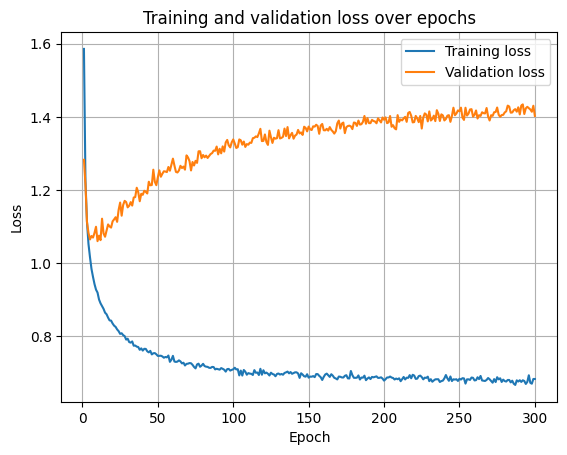

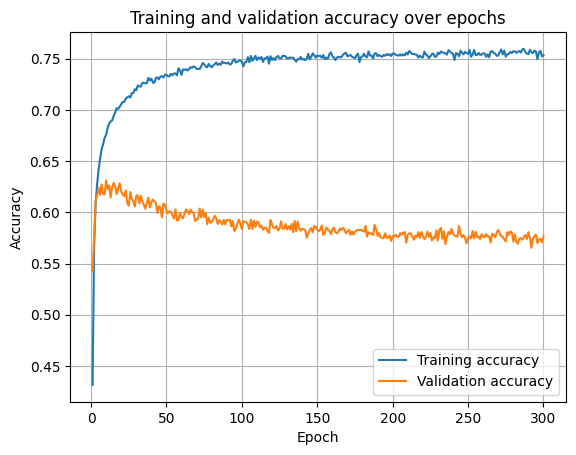

In [ ]:
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# 1. Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# 2. CIFAR-10 Data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
])

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2
)



# 3. CNN model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv block 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Conv block 2
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        # Fully connected layers
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        # First conv block: conv -> tanh -> maxpool
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)   # (B, 16, 16, 16)
        # Second conv block
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)   # (B, 8, 8, 8)
        # Flatten
        x = x.view(-1, 8 * 8 * 8)                        # (B, 512)
        # FC layers
        x = torch.tanh(self.fc1(x))                      # (B, 32)
        x = self.fc2(x)                                  # (B, 10)
        return x


model = Net().to(device)



# 4. Model size

numel_list = [p.numel() for p in model.parameters()]
total_params = sum(numel_list)
print("Parameter counts per tensor:", numel_list)
print("Total number of parameters:", total_params)



# 5. Loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)



# 6. Training loop (returns per-epoch losses AND accuracies)

def training_loop(n_epochs, optimizer, model, loss_fn,
                  train_loader, val_loader, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, n_epochs + 1):
        # ----- Train -----
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # training accuracy
            _, predicted = torch.max(outputs, dim=1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)

        # ----- Validation -----
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item()

                # validation accuracy
                _, predicted = torch.max(outputs, dim=1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)

        # print ALL four metrics for every epoch
        print('{} Epoch {:3d}, Train loss {:.4f}, Val loss {:.4f}, '
              'Train acc {:.4f}, Val acc {:.4f}'.format(
                  datetime.datetime.now(), epoch,
                  avg_train_loss, avg_val_loss,
                  train_accuracy, val_accuracy))

    return train_losses, val_losses, train_accs, val_accs



# 7. Accuracy evaluation (kept as-is)

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)

            total += labels.shape[0]
            correct += int((predicted == labels).sum())

    return correct / total



# 8. Train for 300 epochs and time it

n_epochs = 300
print(f"\nStarting training for {n_epochs} epochs...")

start_time = time.time()
train_losses, val_losses, train_accs, val_accs = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)
total_time = time.time() - start_time

final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
final_train_acc = train_accs[-1]
final_val_acc = val_accs[-1]

print(f"\nTotal training time for {n_epochs} epochs: {total_time:.2f} seconds")
print(f"Final training loss (epoch {n_epochs}): {final_train_loss:.4f}")
print(f"Final validation loss (epoch {n_epochs}): {final_val_loss:.4f}")
print(f"Final training accuracy (epoch {n_epochs}): {final_train_acc:.4f}")
print(f"Final validation accuracy (epoch {n_epochs}): {final_val_acc:.4f}")



# 9. Final evaluation (train & test accuracy)

train_accuracy = evaluate(model, train_loader, device)
test_accuracy = evaluate(model, val_loader, device)

print(f"Training accuracy after {n_epochs} epochs (evaluate): {train_accuracy:.4f}")
print(f"Test (validation) accuracy after {n_epochs} epochs (evaluate): {test_accuracy:.4f}")
print(f"Model size (number of parameters): {total_params}")



# 10. Plot training & validation loss + accuracy

epochs = range(1, n_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss over epochs")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Training accuracy")
plt.plot(epochs, val_accs, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy over epochs")
plt.legend()
plt.grid(True)
plt.show()


**1(b)**

Using device: cuda


100%|██████████| 170M/170M [00:07<00:00, 22.4MB/s]


Parameter counts per tensor: [432, 16, 1152, 8, 576, 8, 4096, 32, 320, 10]
Total number of parameters (model size): 6650

Starting training for 300 epochs...
2025-12-02 15:52:29.607873 Epoch   1, Train loss 1.6958, Val loss 1.4332, Train acc 0.3829, Val acc 0.4831
2025-12-02 15:52:44.893330 Epoch   2, Train loss 1.3453, Val loss 1.2791, Train acc 0.5130, Val acc 0.5389
2025-12-02 15:53:00.554482 Epoch   3, Train loss 1.2339, Val loss 1.2427, Train acc 0.5587, Val acc 0.5559
2025-12-02 15:53:16.372434 Epoch   4, Train loss 1.1738, Val loss 1.1341, Train acc 0.5820, Val acc 0.5928
2025-12-02 15:53:31.963461 Epoch   5, Train loss 1.1266, Val loss 1.1803, Train acc 0.5996, Val acc 0.5807
2025-12-02 15:53:47.225788 Epoch   6, Train loss 1.0935, Val loss 1.1151, Train acc 0.6129, Val acc 0.6061
2025-12-02 15:54:03.000532 Epoch   7, Train loss 1.0724, Val loss 1.1078, Train acc 0.6201, Val acc 0.6041
2025-12-02 15:54:18.452025 Epoch   8, Train loss 1.0525, Val loss 1.0974, Train acc 0.6263, V

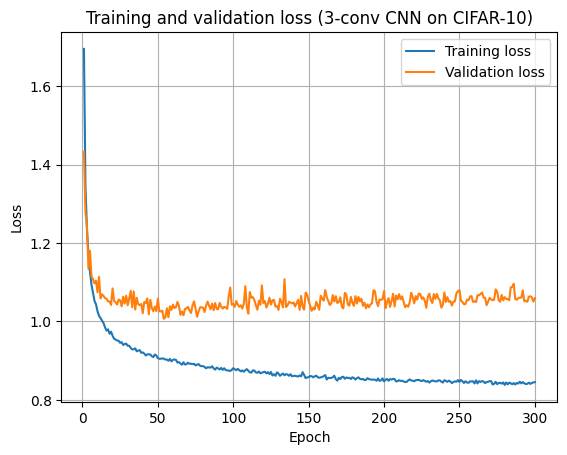

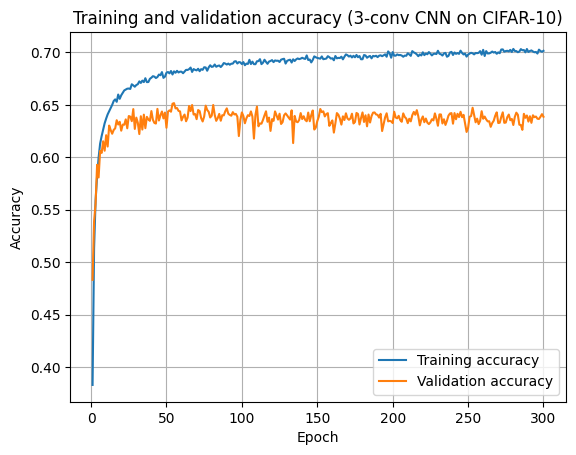

In [1]:
import time
import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


# 1. Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


# 2. CIFAR-10 Data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
])

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)

testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=64, shuffle=True, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    testset, batch_size=64, shuffle=False, num_workers=2
)


# 3. Extended CNN (3 conv blocks, but same widths as 1(a))

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv block 1: 3 -> 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Conv block 2: 16 -> 8  (same as 1(a))
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        # Conv block 3 (extra): 8 -> 8
        self.conv3 = nn.Conv2d(8, 8, kernel_size=3, padding=1)

        # After 3x max-pool(2):
        # 32x32 -> 16x16 -> 8x8 -> 4x4, with 8 channels => 8*4*4 = 128 features
        self.fc1 = nn.Linear(8 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)   # 10 CIFAR-10 classes

    def forward(self, x):
        # Block 1: conv -> tanh -> maxpool
        x = F.max_pool2d(torch.tanh(self.conv1(x)), 2)   # (B, 16, 16, 16)
        # Block 2
        x = F.max_pool2d(torch.tanh(self.conv2(x)), 2)   # (B, 8, 8, 8)
        # Block 3 (extra conv)
        x = F.max_pool2d(torch.tanh(self.conv3(x)), 2)   # (B, 8, 4, 4)

        # Flatten
        x = x.view(-1, 8 * 4 * 4)                       # (B, 128)

        # FC layers
        x = torch.tanh(self.fc1(x))                    # (B, 32)
        x = self.fc2(x)                                # (B, 10)
        return x


model = Net().to(device)


# 4. Model size

numel_list = [p.numel() for p in model.parameters()]
total_params = sum(numel_list)
print("Parameter counts per tensor:", numel_list)
print("Total number of parameters (model size):", total_params)


# 5. Loss and optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)


# 6. Training loop (loss + accuracy per epoch)

def training_loop(n_epochs, optimizer, model, loss_fn,
                  train_loader, val_loader, device):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(1, n_epochs + 1):
        # Train phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            # training accuracy
            _, predicted = torch.max(outputs, dim=1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)
                loss = loss_fn(outputs, labels)
                running_val_loss += loss.item()

                # validation accuracy
                _, predicted = torch.max(outputs, dim=1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)

        # Print metrics for every epoch
        print('{} Epoch {:3d}, Train loss {:.4f}, Val loss {:.4f}, '
              'Train acc {:.4f}, Val acc {:.4f}'.format(
                  datetime.datetime.now(), epoch,
                  avg_train_loss, avg_val_loss,
                  train_accuracy, val_accuracy))

    return train_losses, val_losses, train_accs, val_accs


# 7. Accuracy evaluation (for final report)

def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1)

            total += labels.size(0)
            correct += int((predicted == labels).sum())

    return correct / total


# 8. Train for 300 epochs and time it

n_epochs = 300
print(f"\nStarting training for {n_epochs} epochs...")

start_time = time.time()
train_losses, val_losses, train_accs, val_accs = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
)
total_time = time.time() - start_time

final_train_loss = train_losses[-1]
final_val_loss = val_losses[-1]
final_train_acc = train_accs[-1]
final_val_acc = val_accs[-1]

print(f"\nTotal training time for {n_epochs} epochs: {total_time:.2f} seconds")
print(f"Final training loss (epoch {n_epochs}): {final_train_loss:.4f}")
print(f"Final validation loss (epoch {n_epochs}): {final_val_loss:.4f}")
print(f"Final training accuracy (epoch {n_epochs}): {final_train_acc:.4f}")
print(f"Final validation accuracy (epoch {n_epochs}): {final_val_acc:.4f}")


# 9. Final evaluation on train & test loaders

train_accuracy_eval = evaluate(model, train_loader, device)
test_accuracy_eval = evaluate(model, val_loader, device)

print(f"Training accuracy after {n_epochs} epochs (evaluate): {train_accuracy_eval:.4f}")
print(f"Test (validation) accuracy after {n_epochs} epochs (evaluate): {test_accuracy_eval:.4f}")
print(f"Model size (number of parameters): {total_params}")


# 10. Plots: loss and accuracy over epochs

epochs = range(1, n_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and validation loss (3-conv CNN on CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Training accuracy")
plt.plot(epochs, val_accs, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and validation accuracy (3-conv CNN on CIFAR-10)")
plt.legend()
plt.grid(True)
plt.show()


**2(a)**

Using device: cuda
Model size (number of trainable parameters): 94058

Starting training...
2025-12-02 02:11:35.477296  Epoch   1/300 | Train Loss: 1.8024  Val Loss: 1.5844 | Train Acc: 0.3181  Val Acc: 0.3977
2025-12-02 02:11:50.552093  Epoch   2/300 | Train Loss: 1.4661  Val Loss: 1.3718 | Train Acc: 0.4544  Val Acc: 0.4971
2025-12-02 02:12:06.846513  Epoch   3/300 | Train Loss: 1.2969  Val Loss: 1.2463 | Train Acc: 0.5245  Val Acc: 0.5406
2025-12-02 02:12:22.304406  Epoch   4/300 | Train Loss: 1.1910  Val Loss: 1.5374 | Train Acc: 0.5677  Val Acc: 0.4725
2025-12-02 02:12:37.736998  Epoch   5/300 | Train Loss: 1.0962  Val Loss: 1.2867 | Train Acc: 0.6062  Val Acc: 0.5539
2025-12-02 02:12:53.031959  Epoch   6/300 | Train Loss: 1.0289  Val Loss: 1.2348 | Train Acc: 0.6294  Val Acc: 0.5626
2025-12-02 02:13:08.877430  Epoch   7/300 | Train Loss: 0.9742  Val Loss: 1.0640 | Train Acc: 0.6539  Val Acc: 0.6273
2025-12-02 02:13:24.354165  Epoch   8/300 | Train Loss: 0.9168  Val Loss: 0.9513 |

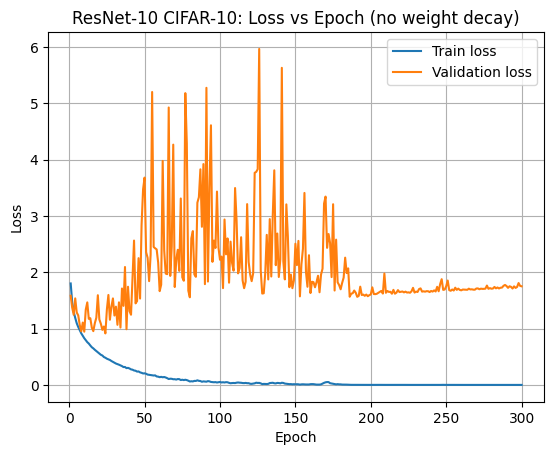

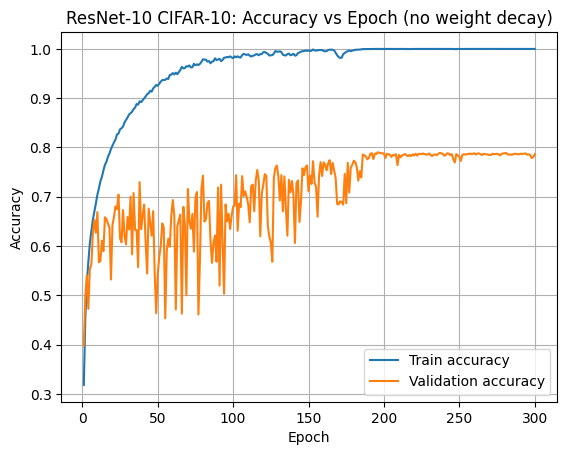

In [ ]:
import time
import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# 1. Device

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")



# 2. CIFAR-10 Data

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    ),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform,
)
testset = torchvision.datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2
)



# 3. ResBlock (with BN + skip)

class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(
            n_chans, n_chans,
            kernel_size=3, padding=1, bias=False
        )
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)

        # Kaiming init
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity="relu")
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = F.relu(out)
        return out + x   # skip connection



# 4. ResNet-10 model

class ResNet10(nn.Module):
    def __init__(self, n_chans=32, n_blocks=10, n_classes=10):
        super().__init__()
        self.n_chans = n_chans

        # Initial conv stem
        self.conv_in = nn.Conv2d(
            3, n_chans, kernel_size=3, padding=1, bias=False
        )
        self.bn_in = nn.BatchNorm2d(n_chans)

        # 10 residual blocks
        blocks = [ResBlock(n_chans) for _ in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        # Global average pooling + final linear layer
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(n_chans, n_classes)

        torch.nn.init.kaiming_normal_(self.conv_in.weight,
                                      nonlinearity="relu")

    def forward(self, x):
        # Stem: conv -> BN -> ReLU -> MaxPool (32x32 -> 16x16)
        out = self.conv_in(x)
        out = self.bn_in(out)
        out = F.relu(out)
        out = F.max_pool2d(out, 2)  # (B, C, 16, 16)

        # Residual blocks
        out = self.blocks(out)

        # Global average pool over 16x16 -> (B, C, 1, 1)
        out = self.global_pool(out)
        out = out.view(out.size(0), -1)  # (B, C)

        # Class logits
        out = self.fc(out)
        return out


model = ResNet10(n_chans=32, n_blocks=10, n_classes=10).to(device)



# 5. Model size

num_params = sum(p.numel() for p in model.parameters())
print(f"Model size (number of trainable parameters): {num_params}")



# 6. Loss & optimizer (no weight decay)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(
    model.parameters(),
    lr=0.01,
    momentum=0.9,
)



# 7. Training + evaluation loop

def run_epoch(model, loader, optimizer=None):
    """
    If optimizer is provided -> training mode, otherwise eval mode.
    Returns (avg_loss, accuracy).
    """
    if optimizer is None:
        model.eval()
        torch.set_grad_enabled(False)
    else:
        model.train()
        torch.set_grad_enabled(True)

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        if optimizer is not None:
            optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        if optimizer is not None:
            loss.backward()
            optimizer.step()

        batch_size = targets.size(0)
        running_loss += loss.item() * batch_size
        _, preds = outputs.max(1)
        correct += preds.eq(targets).sum().item()
        total += batch_size

    avg_loss = running_loss / total
    accuracy = correct / total

    torch.set_grad_enabled(True)
    return avg_loss, accuracy



# 8. Train for 300 epochs

n_epochs = 300
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")
start_time = time.time()

for epoch in range(1, n_epochs + 1):
    train_loss, train_acc = run_epoch(model, train_loader, optimizer)
    val_loss, val_acc = run_epoch(model, val_loader, optimizer=None)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(
        f"{datetime.datetime.now()}  "
        f"Epoch {epoch:3d}/{n_epochs} | "
        f"Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f} | "
        f"Train Acc: {train_acc:.4f}  Val Acc: {val_acc:.4f}"
    )

total_time = time.time() - start_time
print("\nTraining finished.")
print(f"Total training time for {n_epochs} epochs: {total_time:.2f} seconds")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")
print(f"Final training accuracy: {train_accs[-1]:.4f}")
print(f"Final validation accuracy: {val_accs[-1]:.4f}")
print(f"Model size (parameters): {num_params}")



# 9. Plots: loss & accuracy vs epoch

epochs = range(1, n_epochs + 1)

plt.figure()
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet-10 CIFAR-10: Loss vs Epoch (no weight decay)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, train_accs, label="Train accuracy")
plt.plot(epochs, val_accs, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("ResNet-10 CIFAR-10: Accuracy vs Epoch (no weight decay)")
plt.legend()
plt.grid(True)
plt.show()
